In [161]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import ast
import os
import argparse
import sys


In [162]:
# hyperparametr
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dropout_prob = 0.2
batch_size = 32
test_batch_size = 1 # must be fixed to 1
epochs= 1500


In [163]:
def get_args(custom_args=None):
    """
    make parser to get parameters
    """

    parser = argparse.ArgumentParser(
        prog='VAE',
        description='using VAE for 768 dimensional data',
        epilog='Example: python VAE_exp.py --src_filename --output_filename')
    
    parser.add_argument('--src_filename', type = str, default = 'data/prospectus_investment_objective.txt', help='source txt file')
    parser.add_argument('--model_savefolder', type = str, default = 'model/state', help='best model save folder')
    
    # Parse arguments
    if custom_args:
        return parser.parse_args(custom_args)
    else:
        return parser.parse_args()

    # return parser.parse_args()


In [164]:
class CustomDataset(Dataset):
    
    def __init__(self, dataframe):
        
        self.vector = dataframe[4]
        self.id = dataframe[0]
        self.name = dataframe[1]
        self.type_no = dataframe[2]
        self.sentence = dataframe[3]
        
    def __getitem__(self, index):
        
        vector_data = np.array(ast.literal_eval(self.vector[index])).astype(np.float32)
        criteria_no = int(self.type_no[index])
        return vector_data, self.id[index], self.name[index], criteria_no, self.sentence[index]

    def __len__(self):
        
        return len(self.vector)

  

In [165]:
   class VAE(nn.Module):

    def __init__(self, input_dim=768, hidden_dim=[600, 500, 400, 300, 200, 100, 50], latent_dim = 2, device=device):
        
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim[0]),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_prob), 
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_prob), 
            nn.Linear(hidden_dim[1], hidden_dim[2]),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_prob), 
            nn.Linear(hidden_dim[2], hidden_dim[3]),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_prob), 
            nn.Linear(hidden_dim[3], hidden_dim[4]),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_prob), 
            nn.Linear(hidden_dim[4], hidden_dim[5]),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_prob), 
            nn.Linear(hidden_dim[5], hidden_dim[6]),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_prob), 
            nn.Linear(hidden_dim[6], latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_prob), 
            nn.Linear(latent_dim, hidden_dim[6]),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_prob), 
            nn.Linear(hidden_dim[6], hidden_dim[5]),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_prob), 
            nn.Linear(hidden_dim[5], hidden_dim[4]),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_prob), 
            nn.Linear(hidden_dim[4], hidden_dim[3]),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_prob), 
            nn.Linear(hidden_dim[3], hidden_dim[2]),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_prob), 
            nn.Linear(hidden_dim[2], hidden_dim[1]),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_prob), 
            nn.Linear(hidden_dim[1], hidden_dim[0]),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_prob), 
            nn.Linear(hidden_dim[0], input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar, x

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar, _ = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar
        

 

In [166]:
def loss_function(x, x_hat, mean, log_var):
    
    # reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    # loss = reproduction_loss + KLD
    
    reconstruction_loss_fn = nn.MSELoss()
    reconstruction_loss = reconstruction_loss_fn(x_hat, x)
    wr = 1
    wk = 10
    
    loss = wr * reconstruction_loss + wk * KLD
    # loss = reproduction_loss 
    return loss


In [167]:
def train(args, model, optimizer, epochs, device, batch_size, train_loader, test_loader, x_dim=768):
    model.train()
    train_loss_list = []
    test_loss_list = []
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, xf in enumerate(train_loader):
            x = xf[0].to(device)
            
            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            train_loss += loss.item()
            
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Train Loss: ", train_loss/(batch_idx*batch_size))
        
        current_train_loss = train_loss/(batch_idx*batch_size)
        train_loss_list.append(current_train_loss)
        
        if current_train_loss == min(train_loss_list):
            model_savename = 'vae_model_best.pth'
            
            torch.save(model, os.path.join(args.model_savefolder, model_savename))
            
        model.eval()        
        test_loss = 0
        test_batch_size = 1
        for batch_idx, xf in enumerate(test_loader):
            x = xf[0]
            x = x.view(test_batch_size, x_dim).to(device)
            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            test_loss += loss.item()
            

        print("\tEpoch", epoch + 1, "\tAverage Test Loss: ", test_loss/(batch_idx*test_batch_size))
        test_loss_list.append(test_loss/(batch_idx*test_batch_size))
        
        epoch_count = range(1, len(train_loss_list) + 1)

        # Visualize loss history
        plt.plot(epoch_count, train_loss_list, 'r-')
        plt.plot(epoch_count, test_loss_list, 'b-')
        plt.legend(['Training Loss', 'Test Loss'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('train_and test_loss_plot', bbox_inches='tight', dpi =200)
        plt.show()
        
    return train_loss



In [168]:
def main():
    
    custom_args = ['--src_filename', 'data/prospectus_investment_objective.txt', '--model_savefolder', 'model/state']  # Example args
    args = get_args(custom_args)
    
    if not os.path.exists(args.model_savefolder):
        os.makedirs(args.model_savefolder)
        
    df = pd.read_csv(args.src_filename, sep="\t", header=None) 
    dataset = CustomDataset(dataframe=df)

    train_size = int(0.8 * len(dataset)) 
    test_size = len(dataset) - train_size 
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False)
    
    model = VAE().to(device)
   
    optimizer = Adam(model.parameters(), lr=1e-7)
    
    train(args, model, optimizer, epochs, device, batch_size, train_loader, test_loader)
    
    return


	Epoch 1 	Average Train Loss:  2.8761617876981433
	Epoch 1 	Average Test Loss:  3.1223896214225815


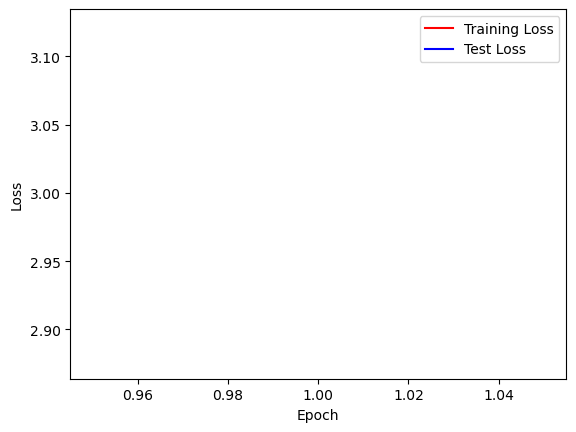

In [169]:
if __name__ == '__main__':
    main()
    
